### Задача
#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy import stats
import pingouin as pg
import numpy as np

Для принятия правильного решения следует рассмотреть доход от платящих пользователей и метрику конверсии из пользователей в клиенты.
Для проверки первой гипотезы, нулевой гипотезой будет та, которая гласит, что никакого статистически значимого изменения по доходу от платящих пользователей не произошло. (Альтернативная - произошло статистически значимое изменение в сторону повышения дохода от платящих пользователей)

In [2]:
# Считываем данные
result_ab_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-z-ravil/Проект_1_Задание_2.csv', sep=';')

In [3]:
# Посмотрим датасет
result_ab_test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [4]:
result_ab_test.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [5]:
# Посмотрим не закралась ли ошибка и все user_id уникальны. Все ок
result_ab_test.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [6]:
# Удостоверимся какая из групп а, и какая b. Все совпадает
result_ab_test.groupby('testgroup', as_index=False) \
    .agg({'revenue':'sum', 'user_id':'count'})

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


In [7]:
# Отделим только клиентов (пользователей которые заплатили) и сгруппируем пользователей по группам, user_id, аггрегируем
# revenue как сумму

In [8]:
result = result_ab_test.query('revenue > 0').groupby(['testgroup', 'user_id'], as_index=False) \
    .agg({'revenue':'sum'})

In [9]:
result

,testgroup,user_id,revenue
0,a,73,351
1,a,342,290
2,a,386,250
3,a,417,37324
4,a,713,255
...,...,...,...
3728,b,403844,3383
3729,b,403995,2793
3730,b,404162,2316
3731,b,404194,2998


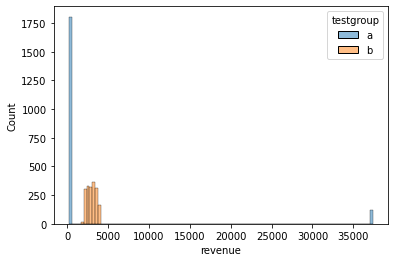

In [10]:
# Посмотрим распределения у групп
sns.histplot(data=result, x = 'revenue', hue='testgroup')

Уже по графику видно, что распределения сильно различаются и для группы а (контрольной) оно сильно отличается от нормального. Но определим нормальность и инструментальным методом (Шапиро Уилка)

In [11]:
result_a = result.query('testgroup == "a"')

In [12]:
stat_a, p_value_a = shapiro(result_a['revenue'])

In [13]:
stat_a, p_value_a

(0.2667924761772156, 0.0)

Подтверждено, распределение группы а  не является нормальным.
Значит для статистически значимого различия будем применять не только ttest, но тест Манна-Уитни, хотя он судя по статье (https://habr.com/ru/companies/avito/articles/709596/) имеет ряд недостатков

In [14]:
pg.ttest(x=result.query('testgroup == "a"')['revenue'],
         y=result.query('testgroup == "b"')['revenue'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


In [15]:
pg.mwu(x=result.query('testgroup == "a"')['revenue'], 
       y=result.query('testgroup == "b"')['revenue'])

,U-val,alternative,p-val,RBC,CLES
MWU,222015.0,two-sided,0.0,0.872407,0.063797


Таким образом, руководствуясь результатами только ttest, мы бы не смогли отклонить нулевую гипотезу об отсутствии
статичтически значимых изменений, но проведя дополнительно тест Манна-Уитни, можем ее отклонить. Значит можем сказать,
что набор предложений в тестовой группе статистически значимо повлиял в сторону повышения ARPU. (и можем считать его более приоритетным)

Рассмотрим вторую метрику: переход от просто пользователей к платящим пользователям ()

In [16]:
result_user_pay = result.groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'pay_user'})

In [17]:
result_user_pay

,testgroup,pay_user
0,a,1928
1,b,1805


In [18]:
result_user_all_pay = result_ab_test.groupby('testgroup', as_index=False).agg({'user_id':'count'}) \
    .rename(columns={'user_id':'all_user'})

In [19]:
result_user_all_pay

,testgroup,all_user
0,a,202103
1,b,202667


In [20]:
data_hyp_2 = result_user_all_pay.merge(result_user_pay, on='testgroup')

In [21]:
data_hyp_2

,testgroup,all_user,pay_user
0,a,202103,1928
1,b,202667,1805


Для проверки второй гипотезы о статистически значимом изменении количества платящих пользователей
бутем применять критерий хи-квадрат. Нулевая гипотеза: Соотношение платящих и неплатящих пользователей в группах 
статистически значимо не изменилось. Альтернативная гипотеза: Соотношение платящих и неплатящих пользователей в группах 
статистически значимо изменилось

In [24]:
table = np.array([[1928, 1805], [202103, 202667]])

In [25]:
chi2_statistic, p_value, dof, expected = chi2_contingency(table)

In [26]:
p_value

0.03824373651044171

Такое значение p_value говорит о том нулевую гипотезу мы должны отклонить, а соотношение платящих и неплатящих пользователей в тестовой группе статистически значимо уменьшилось


Проверив две гипотезы мы видим, что показатель дохода в тестовой группе статистически значимо увеличился, а соотношение платящих и неплатящих пользователей уменьшилось. А значит, сложно сказать, что именно набор из тестовой группы является приоритетным. В то же время, показатель хоход в контрольной группе сильно зависит от малого числа пользователей, которые оставляют в приложении много денег, и если кто-то из них по какой-либо причине "отвалится", это будет серьезным понижением для данного показателя в этой группе. Поэтому я свой выбор оставляю pf набором предложений для тестовой группы.